# Diabetes Severity Classification and Feature Selection

# Project 1 
Let's apply the tools we have learned in the tutorial to a new dataset.

We're going to work with a [diabetes dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html). Download it using the cell below:

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_diabetes
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = "retina"

dataset = load_diabetes()


## Part 1: Getting started [2.5 Marks]
First off, take a look at the `data`, `target` and `feature_names` entries in the `dataset` dictionary. They contain the information we'll be working with here. Then, create a Pandas DataFrame called `df` containing the data and the targets, with the feature names as column headings. If you need help, see [here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) for more details on how to achieve this. **[0.4]**
* How many features do we have in this dataset? **10**
* Determine the median target value. **140.5**
* How many participants have a target value greater than the median target value? **221**

Now add an additional column containing either 0 (if the target value is below the median) or 1 (if the target value is above the median). This will be the new target value to classify the data as "diabetes severity below median" or "diabetes severity above median". **[0.5]**

In [2]:
# Creating a Pandas Dataframe from the dataset
diabetes_df = pd.DataFrame(dataset.data, columns=dataset.feature_names)

# Adding target column to the dataframe
diabetes_df['default_target'] = pd.Series(dataset.target)

target_median = diabetes_df.default_target.median()
num_above_target_median = sum(diabetes_df.default_target > target_median)

# Get basic structure of the Dataset and its target label
print("No. of Features in the Dataset: ", len(diabetes_df.columns)-1)
print("Median target value: ", target_median)
print("Participants with target value greater than the median: ", 
      num_above_target_median)


# Adding new target column classifying data above and below the median
diabetes_df['target_labels'] = (diabetes_df.default_target > target_median).astype(int)

# diabetes_df.head()

No. of Features in the Dataset:  10
Median target value:  140.5
Participants with target value greater than the median:  221


### Splitting the data
It is best practice to have a training set (from which there is a rotating validation subset) and a test set. Our aim here is to (eventually) obtain the best accuracy we can on the test set (we'll do all our tuning on the training/validation sets, however.) 

**Split the dataset** into a train and a test set **"70:30"**, use **``random_state=0``**. The test set is set aside (untouched) for final evaluation, once hyperparameter optimization is complete. **[0.5]**

**Only Split the dataset once within your notebook.** You should not use the `train_test_split` function more than once, regardless of the random state. Keep this in mind for your future projects as well.

In [3]:
from sklearn.model_selection import train_test_split

diabetes_train_data, diabetes_test_data = train_test_split(diabetes_df, 
                                                           test_size=0.3,
                                                           train_size=None,
                                                           random_state=0,
                                                           shuffle=True,
                                                           stratify=None) 


# Get features X for the training dataset
X_train = diabetes_train_data.iloc[:,0:10]

# Get Target (labels), y for the training dataset
y_train = diabetes_train_data.iloc[:,11]

# Get features X for the test dataset
X_test = diabetes_test_data.iloc[:,0:10]

# Get Target (labels), y for the test dataset
y_test = diabetes_test_data.iloc[:,11]


### Effect of Standardization (Visual)
Use `seaborn.lmplot` ([help here](https://seaborn.pydata.org/generated/seaborn.lmplot.html)) to visualize a few features of the training set. Draw a plot where the x-axis is ``age``, the y-axis is ``bmi,`` and the color of each datapoint indicates its class.  **[0.5]**

Standardizing the data is often critical in machine learning. Show a plot as above, but standardize the two features. What's different? **why do they look similar?** Based on your observation, what is the advantage of standardization? **[0.6]**


---
**Answer:**

The plots show identical scatter and regression line trends suggesting that the **original data must have been standardized (and possibly multiplied with a scaling coefficient)**. 

However, **after standardization** of the original data, the scaling factor is changed and it provides an **easy insight to the standard deviations of the age and bmi data**. The mean remains centred at zero. 

Standardization further helps in normalizing the range for different features in the dataset. This prevents high skewness helping in better data visualisation and analysis.




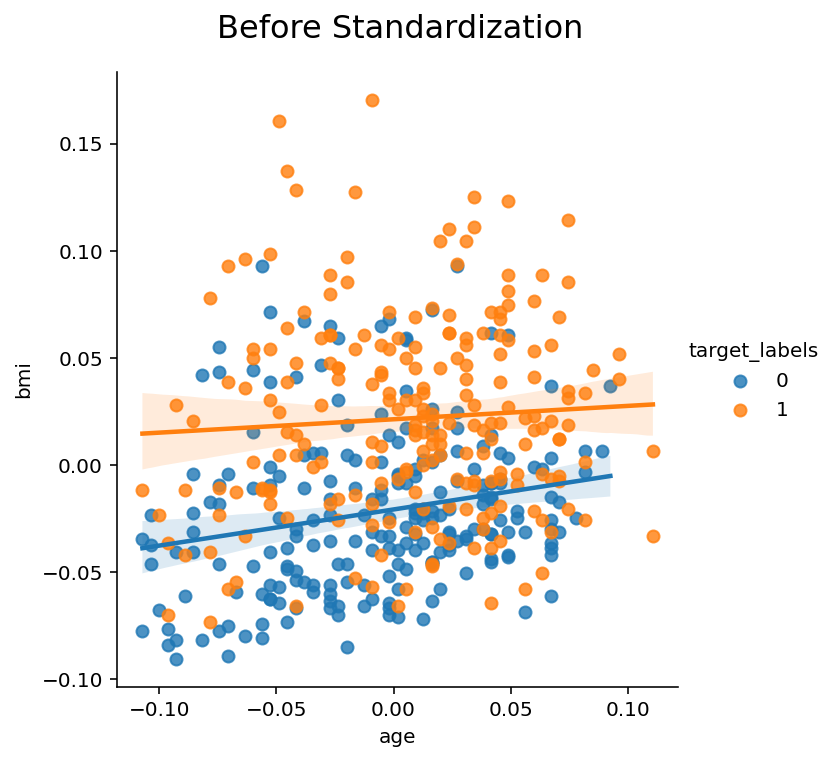

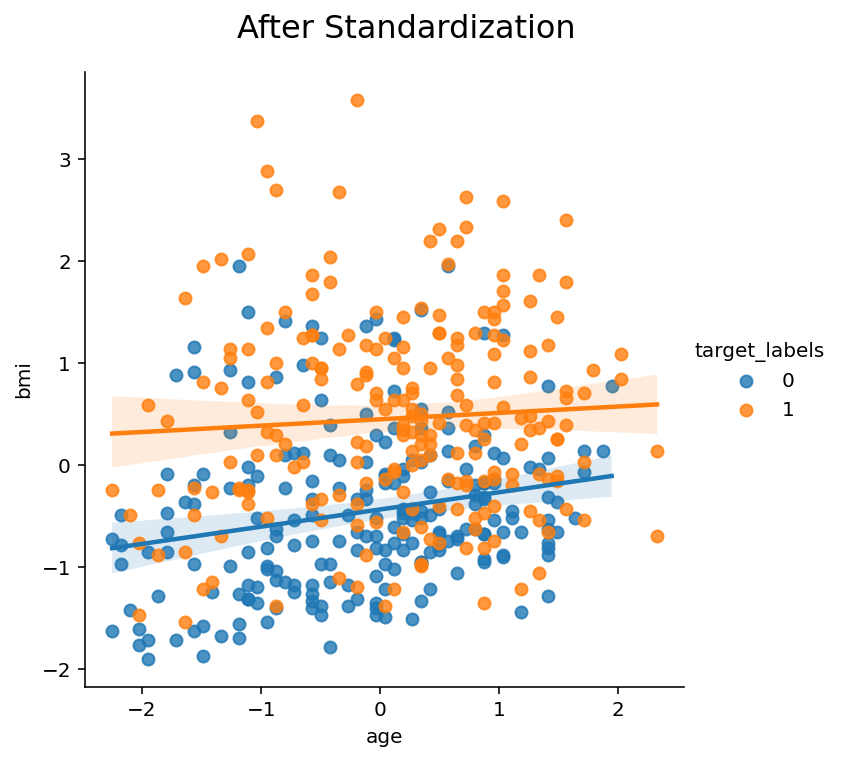

In [4]:
from seaborn.regression import lmplot

plot1 = lmplot(data=diabetes_df, x='age', y='bmi', hue='target_labels')
plot1.fig.suptitle("Before Standardization", fontsize = 16, y=1.05);

# Standardizing age and bmi in the Dataset
mu_age,sigma_age = diabetes_df.age.mean(), diabetes_df.age.std()
diabetes_df_std_ageBMI = diabetes_df.copy()
diabetes_df_std_ageBMI.age -= mu_age
diabetes_df_std_ageBMI.age /= sigma_age

mu_bmi,sigma_bmi = diabetes_df.bmi.mean(), diabetes_df.bmi.std()
diabetes_df_std_ageBMI.bmi -= mu_bmi
diabetes_df_std_ageBMI.bmi /= sigma_bmi

# Plotting the standardized data
plot2 = lmplot(data=diabetes_df_std_ageBMI, x='age', y='bmi', hue='target_labels')
plot2.fig.suptitle("After Standardization", fontsize = 16, y=1.05);

## Part 2: KNN Classifier without Standardization
Normally, standardizing data is a key step in preparing data for a KNN classifier. However, for educational purposes, let's first try to build a model without standardization. Let's create a KNN classifier to predict whether a patient has a diabetes severity that is less than the median or greater than the median. 

Follow these steps: 

1.   Train a KNN Classifier using cross-validation on the dataset. Sweep `k` (number of neighbours) from 1 to 100, and show a plot of the mean cross-validation accuracy vs `k`. **[1]**
2.   What is the best `k`? What is the highest cross-validation accuracy? **[0.5]**
3. Comment on  which ranges of `k` lead to underfitted or overfitted models (hint: compare training and validation curves!). **[0.5]**

---

**Answer**
2. - Best k:  **15**
   - Best Cross-Validation Score:  **0.7543** 

3. From the plot below, it can be seen that at low k values (0-10), the training accuracy is much higher than the cross-validation test accuracy. This suggests that the model is overfitting and thus memorizing the training data. Further, for higher value of k, we do not observe a concrete trend that suggests a underfitted model as both training and cross-validation test sets are giving a fair accuracy (~73%). It is interesting to note that the variance of the cross-validation score is much higher as compared to the training score.  






Best k (number of neighbors):  15
Best Cross validation Score:  0.7543 



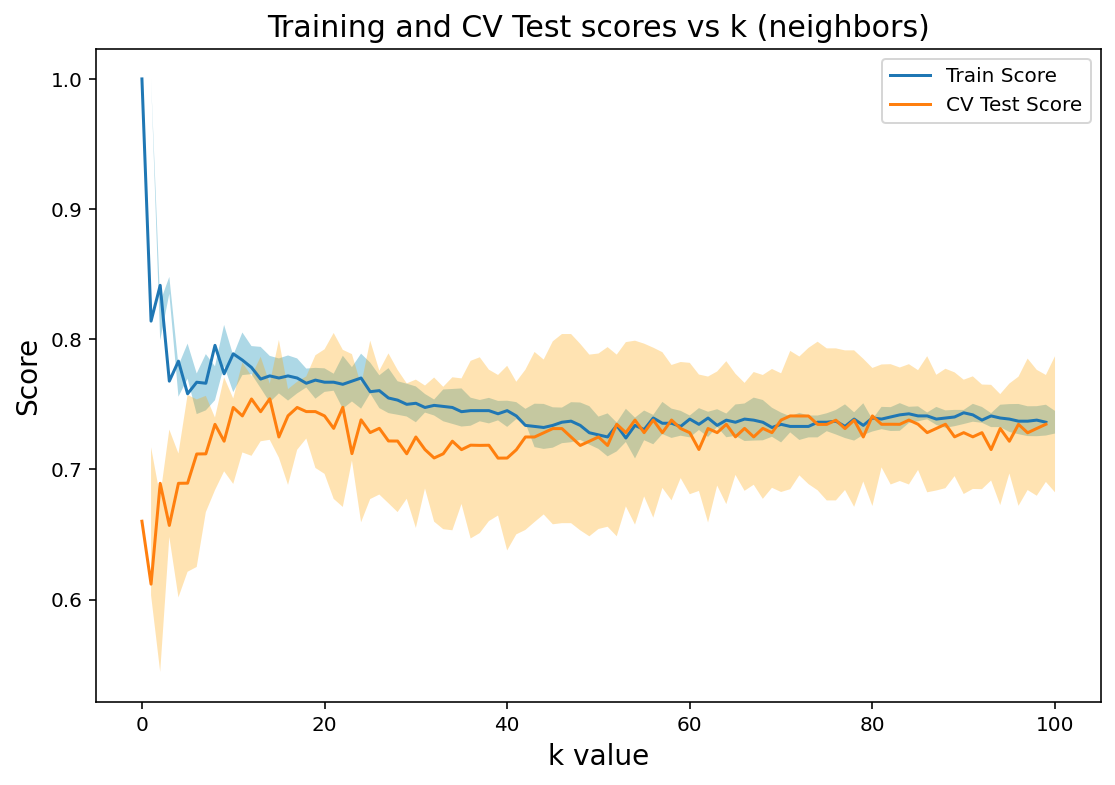

In [5]:
from sklearn import neighbors
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

knn = neighbors.KNeighborsClassifier()
k_sweep = np.arange(1,101)

# Running knn solver for multiple k values
knn_gridSearch = GridSearchCV(knn,
                              param_grid = {'n_neighbors' : k_sweep},
                              cv=5,
                              return_train_score=True)

knn_gridSearch.fit(X_train, y_train)

# storing the GridSearch cross-validation scores
cv_results_dict = knn_gridSearch.cv_results_

# setting up data to visualise variance of the data from the mean
lower_train_score = cv_results_dict['mean_train_score'] - cv_results_dict['std_train_score']
upper_train_score = cv_results_dict['mean_train_score'] + cv_results_dict['std_train_score']

lower_test_score = cv_results_dict['mean_test_score'] - cv_results_dict['std_test_score']
upper_test_score = cv_results_dict['mean_test_score'] + cv_results_dict['std_test_score']

# plotting mean cross-validation accuracy vs k 
fig1, ax1 = plt.subplots(figsize=(9,6))
plt.plot(cv_results_dict['mean_train_score'], color='tab:blue')
plt.plot(cv_results_dict['mean_test_score'], color='tab:orange')
plt.xlabel("k value", size=14)
plt.ylabel("Score", size=14)
plt.legend(['Train Score', 'CV Test Score'])
plt.title("Training and CV Test scores vs k (neighbors)", size=15)
plt.fill_between(k_sweep, lower_train_score, upper_train_score, facecolor='lightblue')
plt.fill_between(k_sweep, lower_test_score, upper_test_score, facecolor='orange', alpha=0.3)

all_feature_best_k = knn_gridSearch.best_params_['n_neighbors']
all_feature_best_score = knn_gridSearch.best_score_
print("Best k (number of neighbors): ", all_feature_best_k)
print("Best Cross validation Score: ", round(all_feature_best_score, 4), '\n')

## Part 3: Feature Selection
In this part, we aim to investigate the importance of each feature on the final classification accuracy. 
If we want to try every possible combination of features, we would have to test  $2^F$ different cases,  where F is the number of features, and in each case, we have to do a hyperparameter search (finding K, in KNN using cross-validation). That will take days!. 

To find more important features we will use a decision tree. based on a decision tree we can compute feature importance that is a metric for our feature selection (code is provided below).

You can use [this link](https://machinelearningmastery.com/calculate-feature-importance-with-python/
) to get familiar with extracting the feature impotance order of machine learning algorithms in Python.

After we identified and removed the least important feature and evaluated a new KNN model on the new set of features, if the stop conditions (see step 7 below) are not met, we need to repeat the process and remove another feature.


Design a function ( `Feature_selector`) that accepts your dataset (X_train , y_train) and a threshold as inputs and: **[1]**
1. Fits a decision tree classifier on the training set.

2. Extracts the feature importance order of the decision tree model.

3. Removes the least important feature based on step 2. 
4. Then, a KNN model is trained on the remaining features. The number of neighbors (`k`) for each KNN model should be tuned using a 5-fold cross-validation.
5. Store the best `mean cross-validation` score and the corresponding `k` (number of neighbours) value in two lists.
6. Go back to step 3 and follow all the steps until you meet the stop condition (step 7). 
 
7. We will stop this process when (1) there is only one feature left, or (2) our cross-validation accuracy is dropped significantly compared to a model that uses all the features. In this function, we accept a threshold as an input argument. For example, if threshold=0.95 we do not continue removing features if our mean cross-validation accuracy after tuning `k` is bellow **0.95 $\times$ Full Feature cross-validation accuracy**.

8. Your function returns the list of removed features, and the corresponding mean cross-validation accuracy and `k` value when a feature was removed.

* Visualize your results by plotting the mean cross-validation accuracy (with a tuned `k` on y axis) vs. the on the number of features (x axis). This plot describes: what is the best cv score with 1 feature, 2 features, 3 features ... and all the features. **[0.5]**

* Plot the best value of `k` (y-axis) vs. the number of features. This plot explains the trend of number of neighbours with respect to the number of features.  **[0.5]**

* State what is the number of essential features for classification and justify your answer. **[1]**
  
  







 

You can use the following piece of code to start training a decision tree classifier and obtain its feature importance order. 
```
from sklearn import tree
dt = tree.DecisionTreeClassifier()
dt.fit(X_train,y_train)
importance = dt.feature_importances_
```


### Feature Selector Function

In [6]:
from sklearn import tree

def Feature_selector (X_train , y_train , tr=0.95):
  dt = tree.DecisionTreeClassifier(random_state=0)
  dt.fit(X_train,y_train)

  # feature_imp stores the array of feature importances (quanititative)
  feature_imp = dt.feature_importances_

  threshold = tr * all_feature_best_score
  reduced_feature_best_score = threshold + 1
  X_train_reduced = X_train
  removed_feature_list = []
  reduced_feature_best_score_list = []
  reduced_feature_best_k_list = []

  while len(feature_imp) > 1 and reduced_feature_best_score > threshold:
    least_important_feature = np.array(feature_imp).argmin()

    drop_label = X_train_reduced.columns[least_important_feature]


    # Drop the least important feature 
    X_train_reduced = X_train_reduced.drop(labels=drop_label, axis=1)

    # obtain the feature importance array of reduced-feature dataset
    dt = tree.DecisionTreeClassifier(random_state=0)
    dt.fit(X_train_reduced,y_train)
    feature_imp = dt.feature_importances_

    # train KNN model
    k_sweep = np.arange(1,101)
    knn_gridSearch = GridSearchCV(knn,
                                  param_grid = {'n_neighbors' : k_sweep},
                                  cv=5,
                                  return_train_score=True)

    knn_gridSearch.fit(X_train_reduced, y_train)

    reduced_feature_best_k = knn_gridSearch.best_params_['n_neighbors']
    reduced_feature_best_score = knn_gridSearch.best_score_
    removed_features = X_train.columns.difference(X_train_reduced.columns)
    removed_feature_list.append(removed_features.to_list())
    reduced_feature_best_score_list.append(reduced_feature_best_score)
    reduced_feature_best_k_list.append(reduced_feature_best_k)

  return removed_feature_list, reduced_feature_best_score_list, reduced_feature_best_k_list

### Result Visualisation

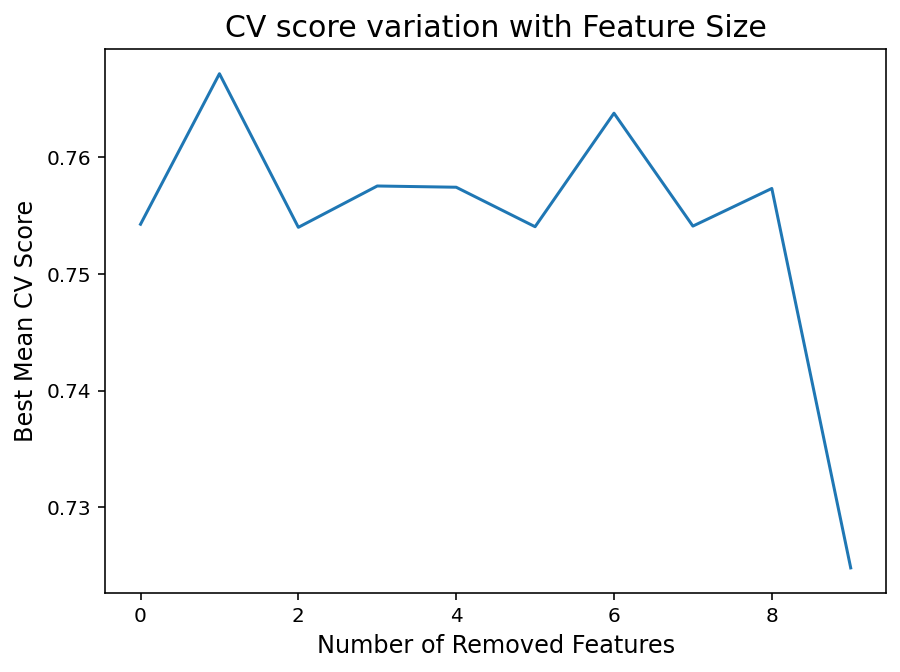

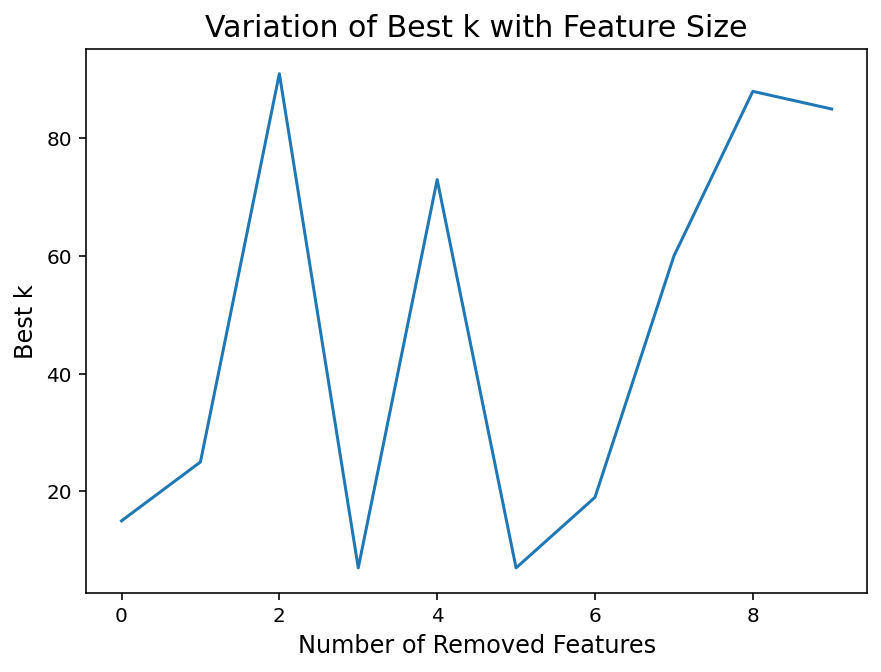

In [7]:
feature_selection_data = Feature_selector(X_train, y_train)

removed_feature_list = feature_selection_data[0].copy()
reduced_feature_best_score_list = feature_selection_data[1].copy()
reduced_feature_best_score_list.insert(0, all_feature_best_score)
reduced_feature_best_k_list = feature_selection_data[2].copy()
reduced_feature_best_k_list.insert(0, all_feature_best_k)

removed_feature_count = [len(x) for x in removed_feature_list]
removed_feature_count.insert(0,0)

fig1, ax1 = plt.subplots(figsize=(7,5))
plt.plot(removed_feature_count, reduced_feature_best_score_list)
plt.xlabel("Number of Removed Features", size=12)
plt.ylabel("Best Mean CV Score", size=12)
plt.title("CV score variation with Feature Size", size=15)
plt.show()

fig1, ax1 = plt.subplots(figsize=(7,5))
plt.plot(removed_feature_count, reduced_feature_best_k_list)
plt.xlabel("Number of Removed Features", size=12)
plt.ylabel("Best k", size=12)
plt.title("Variation of Best k with Feature Size", size=15)
plt.show()


**Answer**

---


From the cross-validation score plot above, there are essentially two candidates providing higher accuracy:
  
1.   **0.767 when 1 feature is removed** 
2.  **0.764 when 6 features are removed**

Since the score difference between these two models is less than 0.4%, we can consider the dataset with 6 features removed without much loss in model accuracy. Therefore we can say that **there are 4 essential features in the dataset for classification**.  


## Part 4: Standardization 

Standardizing the data usually means scaling our data to have a mean of zero and a standard deviation of one. 

**Note:** When we standardize a dataset, do we care if the data points are in our training set or test set? Yes! The training set is available for us to train a model - we can use it however we want. The test set, however, represents a subset of data that is not available for us during training. For example, the test set can represent the data that someone who bought our model would use to see how the model performs (which they are not willing to share with us).
Therefore, we cannot compute the mean or standard deviation of the whole dataset to standardize it - we can only calculate the mean and standard deviation of the training set. However, when we sell a model to someone, we can say what our scalers (mean and standard deviation of our training set) was. They can scale their data (test set) with our training set's mean and standard deviation. Of course, there is no guarantee that the test set would have a mean of zero and a standard deviation of one, but it should work fine.

**To summarize: We fit the StandardScaler only on the training set. We transform both training and test sets with that scaler.**

1. Standardize the training  and test data ([Help](https://scikit-learn.org/stable/modules/preprocessing.html)) 

2. Call your ``Feature_selector`` function on the standardized training data with a threshold of 95\%. 
 * Plot the Cross validation accuracy when we have the standardized data (this part) and the original training data (last part) vs. the Number of features in a single plot (to compare them easily).

3. Discuss how standardization affected your model and its performance? 


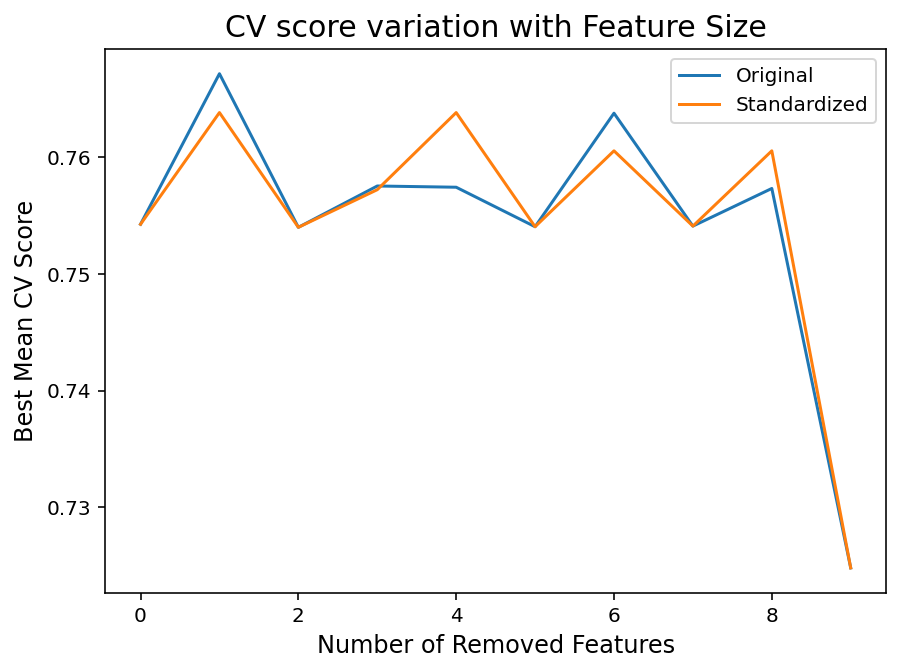

In [8]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X_train)
standardized_train_array = scaler.transform(X_train)
X_train_standardized  = pd.DataFrame(standardized_train_array,
                                     columns=X_train.columns)

standardized_test_array = scaler.transform(X_test)

# Converting standardized dataset into Pandas Dataframe
X_test_standardized  = pd.DataFrame(standardized_test_array,
                                     columns=X_test.columns)


std_feature_selection_data = Feature_selector(X_train_standardized,
                                                       y_train)

removed_std_feature_list = std_feature_selection_data[0].copy()
reduced_std_feature_best_score_list = std_feature_selection_data[1].copy()
reduced_std_feature_best_score_list.insert(0, all_feature_best_score)
reduced_std_feature_best_k_list = std_feature_selection_data[2].copy()
reduced_std_feature_best_k_list.insert(0, all_feature_best_k)

removed_feature_count = [len(x) for x in removed_feature_list]
removed_feature_count.insert(0,0)

fig1, ax1 = plt.subplots(figsize=(7,5))
plt.plot(removed_feature_count, reduced_feature_best_score_list)
plt.plot(removed_feature_count, reduced_std_feature_best_score_list)
plt.xlabel("Number of Removed Features", size=12)
plt.ylabel("Best Mean CV Score", size=12)
plt.legend(['Original', 'Standardized'])
plt.title("CV score variation with Feature Size", size=15)
plt.show()


**Answer**

---
Training the knn model after standardizing the dataset resulted in a plot with closely matching trend of mean CV score vs the number of removed features. There is no drastic perfromance improvement observed after standardization which again suggests that the original dataset must have been normalized.


## Part 5: Decision Tree Classifier [1 Mark]

Train a decision tree classifier on the standardized dataset (read the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) and check the example there.) Tune the `max_depth` and `min_samples_split` parameters of the tree using cross-validation (CV).
 * Compare the decision tree's performance (mean CV score) with KNN, both using all the features. 


Decision Tree Score:  0.731
KNN Score:  0.748


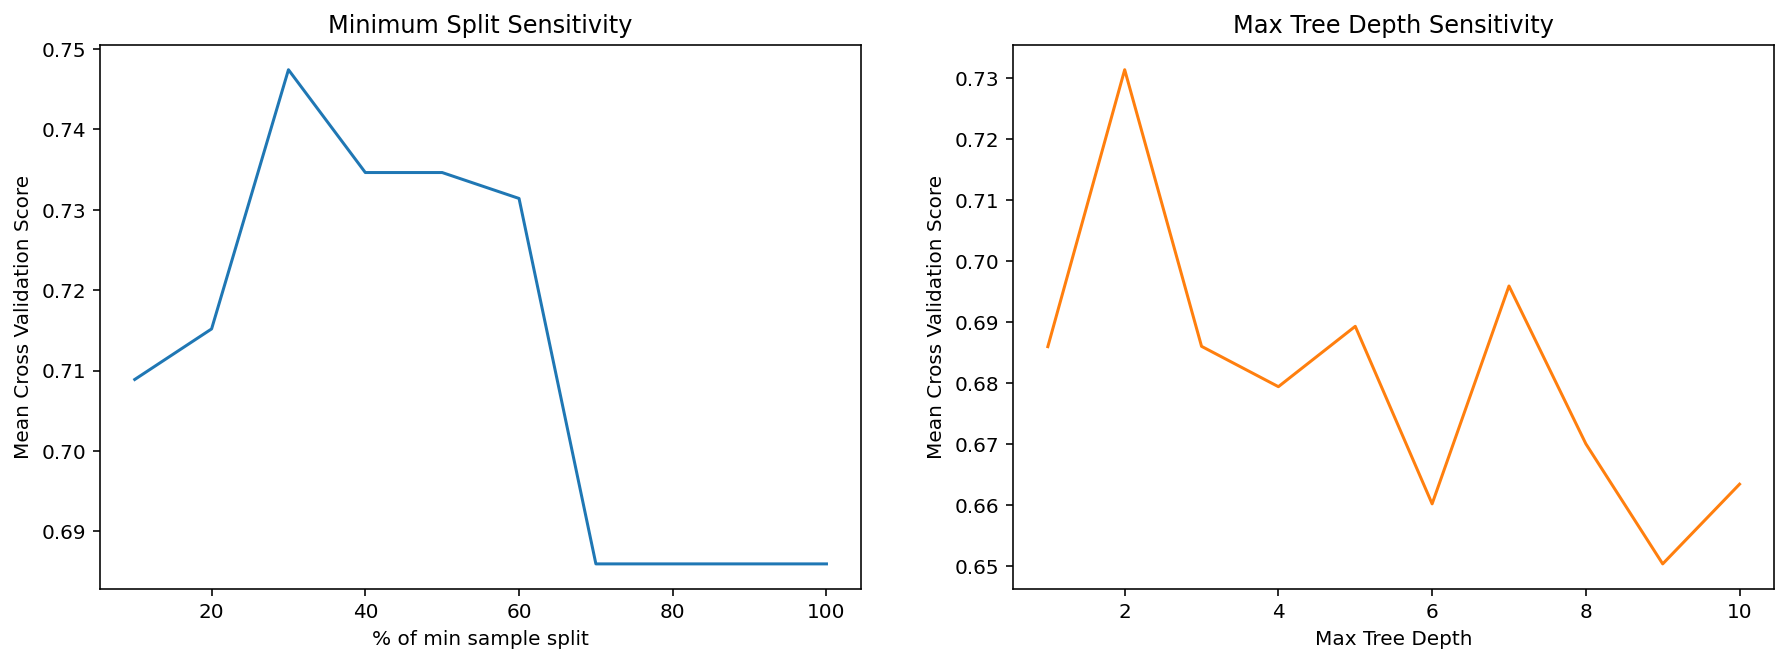

In [11]:
from sklearn.model_selection import cross_val_score
from sklearn import tree

min_samples_split_range = np.linspace(0.1, 1.0, 10, endpoint=True)
max_depth_range = np.linspace(1,10,10, endpoint=True)

minimum_split_sensitivity = []
max_depth_sensitivity = []

# Minimum Split Sensitivity 
for split_value in min_samples_split_range:
  dt = tree.DecisionTreeClassifier(min_samples_split=split_value,
                                 random_state=0)

  dt.fit(X_train_standardized, y_train)
  mean_cv_score_dt = cross_val_score(dt, X_train_standardized, y_train, cv=5).mean()
  minimum_split_sensitivity.append(mean_cv_score_dt)
  
# Max Depth Sensitivity
for max_depth_value in max_depth_range:
  dt = tree.DecisionTreeClassifier(max_depth=max_depth_value,
                                 random_state=0)

  dt.fit(X_train_standardized, y_train)
  mean_cv_score_dt = cross_val_score(dt, X_train_standardized, y_train, cv=5).mean()
  max_depth_sensitivity.append(mean_cv_score_dt)

fig1,(ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
ax1.plot(min_samples_split_range*100, minimum_split_sensitivity, 'tab:blue')
ax1.set(xlabel = "% of min sample split", ylabel = "Mean Cross Validation Score")
ax1.set_title("Minimum Split Sensitivity")

ax2.plot(max_depth_range, max_depth_sensitivity , 'tab:orange')
ax2.set(xlabel = "Max Tree Depth", ylabel = "Mean Cross Validation Score")
ax2.set_title("Max Tree Depth Sensitivity")

# Decision Tree classifier with selected tree depth and minimum split
dt = tree.DecisionTreeClassifier(max_depth=2,
                                 min_samples_split=0.3,
                                 random_state=0)

dt.fit(X_train_standardized, y_train)
mean_cv_score_dt = cross_val_score(dt, X_train_standardized,
                                   y_train, cv=5).mean()

print("Decision Tree Score: ", round(mean_cv_score_dt,3))

knn = neighbors.KNeighborsClassifier(n_neighbors=15)
mean_cv_score_knn = cross_val_score(knn, X_train_standardized, y_train,
                                    cv=5).mean()

print("KNN Score: ", round(mean_cv_score_knn,3))

## Visulaize Tree
# fig2 = plt.subplots(figsize=(10,8))
# tree.plot_tree(dt)
# plt.show()

The decision tree classifier is trained across a range of values for `min_samples_split` and `max_depth` independently. It is observed that the best mean cross-validation accuracy is obtained setting the **minimum split criterion to be 30% of the training dataset and similarly, setting the maximum tree depth to be 2**. 

The **best mean CV score of the Decision tree classifier was 0.731** whereas the **best mean CV score of the KNN classifier with 15 neighbors was 0.748**. Both the evaluations were trained on all the features in the original dataset. 

## Part 6: Test Data [0.5 Mark]

Now that you've created several models, pick your best one (highest CV accuracy) and apply it to the test dataset you had initially set aside. Discuss your results.

In [26]:
from sklearn.metrics import accuracy_score

# get the feature selection data for the standardized dataset
removed_std_feature_list = std_feature_selection_data[0].copy()
reduced_std_feature_best_k_list = std_feature_selection_data[2].copy()

# use the data with 4 least important features removed 
drop_feature_count = 4
X_train_final = X_train_standardized.drop(labels=removed_std_feature_list[drop_feature_count-1],
                                          axis=1)

X_test_final = X_test_standardized.drop(labels=removed_std_feature_list[drop_feature_count-1],
                                        axis=1)

k_final = reduced_std_feature_best_k_list[drop_feature_count-1]

knn_final = neighbors.KNeighborsClassifier(n_neighbors=k_final)
knn_gridSearch = GridSearchCV(knn_final,
                              param_grid = {'n_neighbors' : [k_final]},
                              cv=5,
                              return_train_score=True)

knn_gridSearch.fit(X_train_final, y_train)
cv_score_final  = knn_gridSearch.best_score_

knn_final.fit(X_train_final, y_train)

# mean_cv_score_knn = score_final['test_score'].mean()
print("Mean CV Train Accuracy :", round(cv_score_final, 4))

model_accuracy = accuracy_score(y_test, knn_final.predict(X_test_final))
print("Test Dataset Accuracy:", round(model_accuracy, 4))

Mean CV Train Accuracy : 0.7638
Test Dataset Accuracy: 0.782


From the various datasets trained in this notebook, we select the standardized dataset with 4 least important features removed. (i.e with 6 features). **The mean cross-validation accuracy for this dataset is 0.7638. We train the knn model with k=77 for this specific dataset and obtain a score of 0.782 on the test dataset we had set aside in the beginning.**

References:

https://towardsdatascience.com/decision-trees-in-machine-learning-641b9c4e8052

https://www.analyticsvidhya.com/blog/2021/02/machine-learning-101-decision-tree-algorithm-for-classification/